In [1]:
import MagmaSatPlus as msp
from thermoengine import equilibrate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from ipywidgets import * # not needed for now
%matplotlib inline

In [2]:
#Create a Modeller object where the user defines the model name and version to use for calculatinos
model = msp.Modeller('MagmaSat','1.2.0') #this can take several seconds

#Import excel file
# myfile = msp.ExcelFile('MagmaSat2018-input-molpercent.xlsx', input_type='molpercent') #Enter your filename here
# data = myfile.data

## Plotting degassing paths

In [3]:
#One sample at a time, since I am having trouble getting multiple samples to work

#Closed and Open system can be calculated

#CLOSED SYSTEM (default?)

# #----------------PREAMBLE--------------#
#Create a Modeller object where the user defines the model name and version to use for calculatinos
#model = msp.Modeller('MagmaSat','1.2.0')
# melts = equilibrate.MELTSmodel('1.2.0')

# #Set only Fluid and Liquid phases to True
# phases = melts.get_phase_names()
# oxides = melts.get_oxide_names()
# b = melts.get_phase_inclusion_status()
# for phase in phases:
#     melts.set_phase_inclusion_status({phase:False})

# #set only Fluid and Liquid to True
# melts.set_phase_inclusion_status({'Fluid':True, 'Liquid':True})

#Define your bulk composition
bulk_comp = {'SiO2':  77.5, 
               'TiO2':   0.08, 
               'Al2O3': 12.5, 
               'Fe2O3':  0.207,
               'Cr2O3':  0.0, 
               'FeO':    0.473, 
               'MnO':    0.0,
               'MgO':    0.03, 
               'NiO':    0.0, 
               'CoO':    0.0,
               'CaO':    0.43, 
               'Na2O':   3.98, 
               'K2O':    4.88, 
               'P2O5':   0.0, 
               'H2O':    5.0,
               'CO2':    0.5}

bulk_comp = msp.normalize(bulk_comp)
# bulk_comp_orig = bulk_comp #need this so it can be reset each cell

# feasible = melts.set_bulk_composition(bulk_comp)

temp = 900.0

# data = model.calculate_saturation_pressure(bulk_comp, temp)
# data

# Testing degassing func in library

In [4]:
open_df = model.calculate_degassing_paths(bulk_comp, temp, system='open')
closed_df = model.calculate_degassing_paths(bulk_comp, temp, system='closed')
exsolved_df = model.calculate_degassing_paths(bulk_comp, temp, system='closed', init_vapor=2.0)

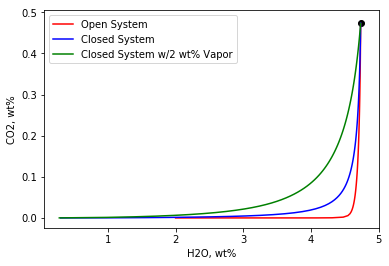

In [5]:
ax = open_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='red', label='Open System')
closed_df.plot(ax=ax, kind='line',x='H2Oliq',y='CO2liq',color='blue', label='Closed System')
exsolved_df.plot(ax=ax, kind='line', x='H2Oliq', y='CO2liq',color='green', label='Closed System w/2 wt% Vapor')
ax.scatter(bulk_comp["H2O"], bulk_comp["CO2"], color='black') #Plot original data point

ax.set_xlabel("H2O, wt%")
ax.set_ylabel("CO2, wt%")

plt.show()

## Closed system

In [ ]:
#closed system
bulk_comp = bulk_comp_orig #reset
feasible = melts.set_bulk_composition(bulk_comp) #this needs to be reset always!

P_array = np.arange(1.0, data['SaturationPressure_MPa']+10.0, 10)
P_array = -np.sort(-P_array)
output = melts.equilibrate_tp(temp, P_array)

pressure = []
H2Oliq = []
CO2liq = []
H2Ofl = []
CO2fl = []
fluid_wtper = []
for i in range(len(output)):
    (status, temp, p, xmlout) = output[i]
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    
    pressure.append(p)
    H2Oliq.append(liq_comp["H2O"])
    CO2liq.append(liq_comp["CO2"])
    try:
        H2Ofl.append(fl_comp["H2O"])
    except:
        H2Ofl.append(0)
    try:
        CO2fl.append(fl_comp["CO2"])
    except:
        CO2fl.append(0)
    fluid_wtper.append(fl_wtper)

bulk_comp = bulk_comp_orig
feasible = melts.set_bulk_composition(bulk_comp)
closed_degassing_df = pd.DataFrame(list(zip(pressure, H2Oliq, CO2liq, H2Ofl, CO2fl, fluid_wtper)), 
                            columns =['pressure', 'H2Oliq', 'CO2liq', 'H2Ofl', 'CO2fl', 'fluid_wtper'])

#print(closed_degassing_df)
closed_degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='blue')
plt.show()


## Closed system starting with exsolved vapor

In [ ]:
#closed system plus fluid
bulk_comp = bulk_comp_orig
feasible = melts.set_bulk_composition(bulk_comp) #this needs to be reset always!

#----------USER INPUT----------#
#User needs to specify amount of exsolved vapor to begin with
exsolved_vapor_wtper = 2.0 #this is 2% starting exsolved vapor

P_array = np.arange(1.0, data['SaturationPressure_MPa'], 10)
P_array = -np.sort(-P_array)
fl_wtper = data["FluidSystem_wtper"]

while fl_wtper <= exsolved_vapor_wtper:
    output = melts.equilibrate_tp(temp, data["SaturationPressure_MPa"], initialize=True)
    (status, temp, p, xmlout) = output[0]
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    print(fl_wtper)
    bulk_comp["H2O"] += fl_comp["H2O"]*0.0005
    bulk_comp["CO2"] += fl_comp["CO2"]*0.0005
    bulk_comp = msp.normalize(bulk_comp)
    feasible = melts.set_bulk_composition(bulk_comp)

output = melts.equilibrate_tp(temp, P_array, initialize=True)

pressure = []
H2Oliq = []
CO2liq = []
H2Ofl = []
CO2fl = []
fluid_wtper = []
for i in range(len(output)):
    (status, temp, p, xmlout) = output[i]
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    
    pressure.append(p)
    H2Oliq.append(liq_comp["H2O"])
    CO2liq.append(liq_comp["CO2"])
    try:
        H2Ofl.append(fl_comp["H2O"])
    except:
        H2Ofl.append(0)
    try:
        CO2fl.append(fl_comp["CO2"])
    except:
        CO2fl.append(0)
    fluid_wtper.append(fl_wtper)

bulk_comp = bulk_comp_orig
feasible = melts.set_bulk_composition(bulk_comp)
fl_wtper = data["FluidSystem_wtper"]
exsolved_degassing_df = pd.DataFrame(list(zip(pressure, H2Oliq, CO2liq, H2Ofl, CO2fl, fluid_wtper)), 
                            columns =['pressure', 'H2Oliq', 'CO2liq', 'H2Ofl', 'CO2fl', 'fluid_wtper'])

#print(exsolved_degassing_df)
exsolved_degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='green')
plt.show()



## Open system 

In [ ]:
#open system
bulk_comp = bulk_comp_orig
feasible = melts.set_bulk_composition(bulk_comp) #this needs to be reset always!

bulk_comp = msp.normalize(bulk_comp)
P_array = np.arange(1.0, data['SaturationPressure_MPa']+10.0, 10)
P_array = -np.sort(-P_array)

pressure = []
H2Oliq = []
CO2liq = []
H2Ofl = []
CO2fl = []
fluid_wtper = []
for i in P_array:
    fl_mass = 0.0
    output = melts.equilibrate_tp(temp, i)
    (status, temp, p, xmlout) = output[0]
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    
    if fl_mass > 0:
        pressure.append(p)
        H2Oliq.append(liq_comp["H2O"])
        CO2liq.append(liq_comp["CO2"])
        try:
            H2Ofl.append(fl_comp["H2O"])
        except:
            H2Ofl.append(0)
        try:
            CO2fl.append(fl_comp["CO2"])
        except:
            CO2fl.append(0)
        fluid_wtper.append(fl_wtper)
    
    
        bulk_comp["H2O"] = liq_comp["H2O"]
        bulk_comp["CO2"] = liq_comp["CO2"]
        bulk_comp = msp.normalize(bulk_comp)

        feasible = melts.set_bulk_composition(bulk_comp)

bulk_comp = bulk_comp_orig
feasible = melts.set_bulk_composition(bulk_comp) #this needs to be reset always!
open_degassing_df = pd.DataFrame(list(zip(pressure, H2Oliq, CO2liq, H2Ofl, CO2fl, fluid_wtper)), 
                            columns =['pressure', 'H2Oliq', 'CO2liq', 'H2Ofl', 'CO2fl', 'fluid_wtper'])

#print(open_degassing_df)
open_degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='red')
plt.show()

## Plotting testing

In [ ]:
ax = open_degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='red', label='Open System')
closed_degassing_df.plot(ax=ax, kind='line',x='H2Oliq',y='CO2liq',color='blue', label='Closed System')
exsolved_degassing_df.plot(ax=ax, kind='line', x='H2Oliq', y='CO2liq',color='green', label='Closed System w/2 wt% Vapor')
plt.scatter(data["H2O"], data["CO2"], color='black') #Plot original data point

ax.set_xlabel("H2O, wt%")
ax.set_ylabel("CO2, wt%")

## Multi sample testing

In [ ]:
degassing_dict = {index: {'Label': [], 'press': [], 'H2Oliq': [], 'CO2liq': [], 'H2Ofl': [],
                          'CO2fl': [], 'fl_wtper': []} for index, row in data.iterrows()}
df_list = []
for index, row in data.iterrows():
    bulk_comp = {oxide: row[oxide] for oxide in oxides}
    feasible = melts.set_bulk_composition(bulk_comp)

    press = row["SaturationPressure_MPa"]
    p_array = np.arange(1.0, press, 10.0)
    p_array = -np.sort(-p_array)
    print(p_array)

    if file_has_temp == True:
        temp = row[temp] #test this

    output = melts.equilibrate_tp(temp, p_array, initialize=True)
    output2 = melts.equilibrate_tp(temp, press)
    (status, t, p, xmlout) = output[0]
    #melts.output_summary(xmlout)
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)

    for key, value in degassing_dict.items():
        if key == index:
            value['Label'].append(index)
            value['press'].append(press)
            value['H2Oliq'].append(liq_comp['H2O'])
            value['CO2liq'].append(liq_comp['CO2'])
            value['H2Ofl'].append(fl_comp['H2O'])
            value['CO2fl'].append(fl_comp['CO2'])
            value['fl_wtper'].append(fl_wtper)

    
    degassing_data = pd.DataFrame.from_dict(degassing_dict, orient='index')
    df_list.append(degassing_data)
    
result = pd.concat(df_list)
result

In [ ]:
column_names = {'Label': [], 'Press': [], 'H2Oliq': [],
                'CO2liq': [], 'H2Ofl': [], 'CO2fl': [],
                'fl_wtper': []}
degassing_paths_df = pd.DataFrame(column_names)
degassing_paths_df

In [ ]:
df_list = []
for index, key in degassing_dict.items():
    df = pd.DataFrame.from_dict(value)
    for index, row in df.iterrows():
        row['Label'] = index
    print (df)
    df_list.append(df)
#print (df_list)

In [ ]:
rowname = []
all_dfs = pd.DataFrame{}
for index, row in degassing_dict.items():
    rowname.append(index)
    d = {
         'press': [i for i in degassing_dict[index]['press']],
         'H2Ofl': [j for j in degassing_dict[index]['H2Ofl']]}
    df = pd.DataFrame(d)
    
print(df)
    

## Calculate saturation pressures

In [ ]:
#Test passing an ExcelFile object
pressures = model.calculate_saturation_pressure(myfile, 900.0)
# print(pressures)

## Plotting isobars and isopleths

In [ ]:
#To get composition from a specific sample in the input data:
SampleName = 'BT-ex'
bulk_comp = myfile.get_sample_oxide_comp(sample=SampleName)
feasible = model.melts.set_bulk_composition(bulk_comp)

#Uncomment the line below to print the sample composition
#print(bulk_comp) 

#Alternatively, you can enter a single melt composition manually below:
# bulk_comp = {'SiO2':  77.5, 
#                'TiO2':   0.08, 
#                'Al2O3': 12.5, 
#                'Fe2O3':  0.207,
#                'Cr2O3':  0.0, 
#                'FeO':    0.473, 
#                'MnO':    0.0,
#                'MgO':    0.03, 
#                'NiO':    0.0, 
#                'CoO':    0.0,
#                'CaO':    0.43, 
#                'Na2O':   3.98, 
#                'K2O':    4.88, 
#                'P2O5':   0.0, 
#                'H2O':    10.0,
#                'CO2':    1.0}

# feasible = model.melts.set_bulk_composition(bulk_comp)

In [ ]:
temperature = 1000.0

#Use the below lines to define pressures as minimum, maximum, and interval:
pressure_min = 100.0
pressure_max = 500.0
pressure_int = 100.0

#Alternatively, pressures can be defined individually as a list:
#pressures = [100.0, 200.0, 300.0, 400.0, 500.0]

In [ ]:
isobars = model.calculate_isobars_and_isopleths(bulk_comp, temperature, pressure_min=pressure_min, pressure_max=pressure_max, pressure_int=pressure_int)

In [ ]:
model.plot_isobars_and_isopleths(isobars)